## Game plan!

How it will work: 
    1. We use Spotify API to gather top study playlists somehow into a giant database --use "get several tracks" to get data abt all songs in the playlist  
    2. We cluster the songs by their attributes and use elbow method to determine clusters  
    3. We create categories of the clusters by analyzing its top genres?   
    4. Personality test for students to get their ideal playlist!  

In [5]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Step 1: Collect playlists
We should have a final dataframe where each row is a song and the columns are: song id, artists id, danceability, energy, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration, count

In [2]:
# spotify api credentials
cid = 'af25a5ab6fac412a9f644871d866df12' 
secret = '374a71348a9943ba8b585b9c9466feb6'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout = 10, retries = 10)

### Get a massive list of non-Spotify playlists

In [10]:
'''
takes in playlist id and the number of tracks on it
for each iteration, it finds id and artist information for 50 songs on the playlist
returns a list of ids
'''
def get_track_ids(playlist_id, num_tracks):
# iterate through track ids in the playlist to create giant list of track ids
    ids = []
    limit = 50
    
    for i in range(0, num_tracks, limit):
        sub_playlist = sp.playlist_items(playlist_id, fields='items(track(id, name))', market= 'us', limit=limit, offset=i) 
        
        # check for None type
        tracks = [track for track in sub_playlist['items'] if track['track'] is not None]
        
        for i, tr in enumerate(tracks): 
            ids.append(tr['track']['id'])
    
    return ids

In [8]:
# create final dataframe
columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 
           'time_signature']
study_tracks = pd.DataFrame(columns=columns)

# create sentiment analyzer object 
sid = SentimentIntensityAnalyzer()

# variables
playlist_id = []
num_tracks = []
num_playlists = 900 # analyze nine hundred study playlists (this is max available)
playlist_limit = 50
description = []
sentiment = []
spotify_study = 0

# collect playlist IDs
for i in range(0,num_playlists,playlist_limit):
    playlist_results = sp.search(q='study', type='playlist', market= 'us', limit=playlist_limit,offset=i) 
    for i, pl in enumerate(playlist_results['playlists']['items']):
    # don't want spotify music
        if pl['owner']['id'] == 'spotify': 
            spotify_study+=1
            continue
        else:
            # get playlist ID and num tracks 
            playlist_id.append(pl['uri'].split(':')[2]) 
            num_tracks.append(pl['tracks']['total'])
            descript = pl['description']
            description.append(descript)
            sentiment.append(sid.polarity_scores(descript)['compound'])
print('Done Collecting Playlist IDs!')
print('Number of Spotify Playlists ommitted: ', spotify_study)
print('Number of Playlists collected: ', len(playlist_id))

# create playlist dataframe
playlist_df = pd.DataFrame({'playlist_id': playlist_id, 'num_tracks': num_tracks, 'description': description,
                           'sentiment': sentiment})

Done Collecting Playlist IDs!
Number of Spotify Playlists ommitted:  99
Number of Playlists collected:  801


In [11]:
track_ids = []
num_playlists_done = 0

# remove duplicate playlists 
playlist_df = playlist_df.groupby('playlist_id').max().reset_index()

# update values
playlist_id = playlist_df['playlist_id'].to_list()
num_tracks = playlist_df['num_tracks'].to_list()
print('Collecting tracks for ', len(playlist_id), ' playlists!')

# add each track's audio features onto study tracks
for i in range(len(playlist_id)):
    if num_playlists_done % 25 == 0:
        print(num_playlists_done, ' done!')
        print('continuing...')
        
    # extract track ids from each playlist
    track_ids = track_ids + get_track_ids(playlist_id[i], num_tracks[i])
    
    num_playlists_done+=1

print('Done collecting track IDs!')

0  done!
continuing...
25  done!
continuing...
50  done!
continuing...
75  done!
continuing...
100  done!
continuing...
125  done!
continuing...
150  done!
continuing...
175  done!
continuing...
200  done!
continuing...
225  done!
continuing...
250  done!
continuing...
275  done!
continuing...
300  done!
continuing...
325  done!
continuing...
350  done!
continuing...
375  done!
continuing...
400  done!
continuing...
425  done!
continuing...
450  done!
continuing...
475  done!
continuing...
500  done!
continuing...
525  done!
continuing...
550  done!
continuing...
575  done!
continuing...
600  done!
continuing...
625  done!
continuing...
650  done!
continuing...
675  done!
continuing...
700  done!
continuing...
725  done!
continuing...
750  done!
continuing...
775  done!
continuing...
Done collecting track IDs!


In [27]:
print('number of track ids: ', len(track_ids))

# find number of unique tracks:
unique_tracks = pd.DataFrame({'track_id':track_ids})
unique_tracks = unique_tracks.value_counts().reset_index()
unique_tracks.columns = ['track_id', 'count']
unique_tracks

print('number of unique tracks: ', unique_tracks.shape[0])
unique_tracks.head()

number of track ids:  185255
number of unique tracks:  118304


track_id  count
0  4UaGQ2D4MBuRBWumZO52Ma     89
1  0V5cvmTKsYmF5FmGGEAfmS     66
2  7eo2HVkRxrDU3bQPwEiIBT     64
3  0yc6Gst2xkRu0eMLeRMGCX     56
4  1BncfTJAWxrsxyT9culBrj     55

In [39]:
unique_track_ids = unique_tracks['track_id'].to_list()

print('Studying audio features for ', len(unique_track_ids), ' tracks!')

track_limit = 100
tracks_analyzed = 0

# use track id list to add audio features to study_tracks
for i in range(0, len(unique_track_ids), track_limit): 
    id_chunk = track_ids[i:i+track_limit] 
    # filter None
    id_chunk = [element for element in id_chunk if element is not None] 
    tracks_features = sp.audio_features(tracks=id_chunk) 
    
    # filter None
    tracks_features = [element for element in tracks_features if element is not None] 
    mini_tracks_df = pd.DataFrame(tracks_features)
    study_tracks = pd.concat([study_tracks, mini_tracks_df])
    
    tracks_analyzed += len(tracks_features)


Studying audio features for  118304  tracks!
Done with:  108000 !
...


In [46]:
# merge occurance of each track 
study_tracks = pd.merge(study_tracks, unique_tracks, left_on = 'id', right_on='track_id').sort_values(by='count', ascending=False)
study_tracks

danceability  energy key  loudness mode  speechiness  acousticness  \
123763        0.6450  0.8490   8    -3.198    0       0.2000         0.226   
123762        0.6450  0.8490   8    -3.198    0       0.2000         0.226   
123771        0.6450  0.8490   8    -3.198    0       0.2000         0.226   
123770        0.6450  0.8490   8    -3.198    0       0.2000         0.226   
123769        0.6450  0.8490   8    -3.198    0       0.2000         0.226   
...              ...     ...  ..       ...  ...          ...           ...   
91566         0.0696  0.0831  10   -19.418    1       0.0447         0.965   
36177         0.1810  0.0459   2   -25.083    1       0.0386         0.967   
36178         0.1810  0.0459   2   -25.083    1       0.0386         0.967   
91563         0.4410  0.1460   7   -21.754    0       0.0368         0.761   
142257        0.0752  0.0689   7   -23.116    0       0.0492         0.960   

        instrumentalness  liveness  valence    tempo            type  \
123763             0.000    0.1040   0.8550  165.008  audio_features   
123762             0.000    0.1040   0.8550  165.008  audio_features   
123771             0.000    0.1040   0.8550  165.008  audio_features   
123770             0.000    0.1040   0.8550  165.008  audio_features   
123769             0.000    0.1040   0.8550  165.008  audio_features   
...                  ...       ...      ...      ...             ...   
91566              0.747    0.1110   0.0345   58.675  audio_features   
36177              0.915    0.1790   0.0584   91.782  audio_features   
36178              0.915    0.1790   0.0584   91.782  audio_features   
91563              0.541    0.2270   0.0629  119.975  audio_features   
142257             0.929    0.0882   0.0321   74.222  audio_features   

                            id                                   uri  \
123763  4UaGQ2D4MBuRBWumZO52Ma  spotify:track:4UaGQ2D4MBuRBWumZO52Ma   
123762  4UaGQ2D4MBuRBWumZO52Ma  spotify:track:4UaGQ2D4MBuRBWumZO52Ma   
123771  4UaGQ2D4MBuRBWumZO52Ma  spotify:track:4UaGQ2D4MBuRBWumZO52Ma   
123770  4UaGQ2D4MBuRBWumZO52Ma  spotify:track:4UaGQ2D4MBuRBWumZO52Ma   
123769  4UaGQ2D4MBuRBWumZO52Ma  spotify:track:4UaGQ2D4MBuRBWumZO52Ma   
...                        ...                                   ...   
91566   3QY0L2G2t15KFJ23yGokIl  spotify:track:3QY0L2G2t15KFJ23yGokIl   
36177   0CUGJRSyfw9i2Wi6HCF3Ct  spotify:track:0CUGJRSyfw9i2Wi6HCF3Ct   
36178   0CUGJRSyfw9i2Wi6HCF3Ct  spotify:track:0CUGJRSyfw9i2Wi6HCF3Ct   
91563   36WyxaGS7hm4hJHqUBOSUG  spotify:track:36WyxaGS7hm4hJHqUBOSUG   
142257  3uVPdCnO0tdVx2B5iVxyZq  spotify:track:3uVPdCnO0tdVx2B5iVxyZq   

                                               track_href  \
123763  https://api.spotify.com/v1/tracks/4UaGQ2D4MBuR...   
123762  https://api.spotify.com/v1/tracks/4UaGQ2D4MBuR...   
123771  https://api.spotify.com/v1/tracks/4UaGQ2D4MBuR...   
123770  https://api.spotify.com/v1/tracks/4UaGQ2D4MBuR...   
123769  https://api.spotify.com/v1/tracks/4UaGQ2D4MBuR...   
...                                                   ...   
91566   https://api.spotify.com/v1/tracks/3QY0L2G2t15K...   
36177   https://api.spotify.com/v1/tracks/0CUGJRSyfw9i...   
36178   https://api.spotify.com/v1/tracks/0CUGJRSyfw9i...   
91563   https://api.spotify.com/v1/tracks/36WyxaGS7hm4...   
142257  https://api.spotify.com/v1/tracks/3uVPdCnO0tdV...   

                                             analysis_url duration_ms  \
123763  https://api.spotify.com/v1/audio-analysis/4UaG...      180560   
123762  https://api.spotify.com/v1/audio-analysis/4UaG...      180560   
123771  https://api.spotify.com/v1/audio-analysis/4UaG...      180560   
123770  https://api.spotify.com/v1/audio-analysis/4UaG...      180560   
123769  https://api.spotify.com/v1/audio-analysis/4UaG...      180560   
...                                                   ...         ...   
91566   https://api.spotify.com/v1/audio-analysis/3QY0...      153907   
36177   https://api.spot

# Exploratory Data Analysis

### Part 1: Exploring the playlists

From the descriptive statistics, we can see that each playlist averages 237 songs (which seems very high) and the average sentiment of its description is positive. 

In [22]:
playlist_df.describe()

num_tracks   sentiment
count   780.000000  780.000000
mean    237.652564    0.220945
std     428.029930    0.354774
min       2.000000   -0.877900
25%      67.750000    0.000000
50%     120.500000    0.000000
75%     243.250000    0.493900
max    5040.000000    0.981600

Text(0.5, 1.0, 'Distribution of Tracks Per Playlist')

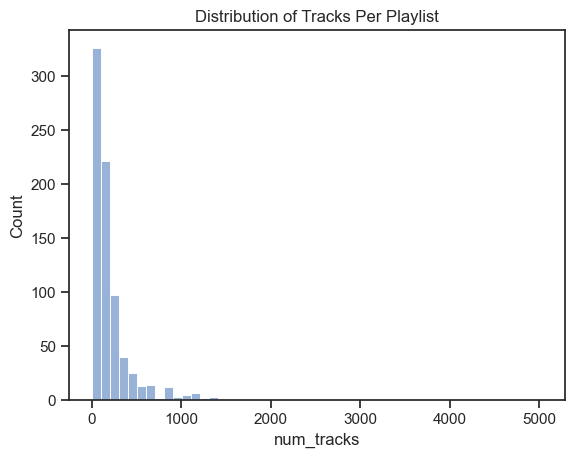

In [5]:
sns.set_palette("pastel") 
sns.set(style = 'ticks')
sns.histplot(playlist_df['num_tracks'], bins=50, color='#79C', kde=False).set_title('Distribution of Tracks Per Playlist')

### Which playlist has 5 thousand songs?

In [23]:
playlist_df[playlist_df['num_tracks'] > 2000].sort_values(by='num_tracks', ascending=False)

playlist_id  num_tracks  \
675  6jUXWvAQhTMFyPECJGJmoX        5040   
110  1965t0Sekx2fUwU5eT8pOY        4446   
234  2PmpA2CuH8cYxDvMTdvMWX        4041   
608  69KzikJmXzl00stYIaJkKn        3676   
615  6ENpYVmaiAF540AaIDwpHZ        3197   
128  1OFYueY9xdzvJESetZaiKw        3063   
47   0XkEWj2EpR7F0IfMUjzgY4        2974   
112  1AhjuGs9C2VY1ql1JhaEe5        2388   

                                           description  sentiment  \
675  Low fi music and study lofi selection of the c...     0.4019   
110                                                NaN     0.0000   
234             Regularly updated, personally curated.     0.0000   
608                                                NaN     0.0000   
615  Keep the demons away day or night with continu...     0.0000   
128            Press shuffle and get some work done :)     0.4588   
47   Listen to all of your favorites in pop and ind...     0.5574   
112                                                NaN     0.0000   

                                                  name  
675  Low-Fi Music 2024 | Lofi Hip Hop Music | Lo-Fi...  
110                                        Study Piano  
234        Lofi Beats for Study - No Voices - No Words  
608                                         Study time  
615      Gregorian Chants for Sleep, Study & Solitude   
128                                  Chill Study Beats  
47                            Instrumental Study Music  
112                            Fig Plucker Study Guide

### Relationship between Description Sentiment Score and Number of Tracks 

<Axes: xlabel='sentiment', ylabel='num_tracks'>

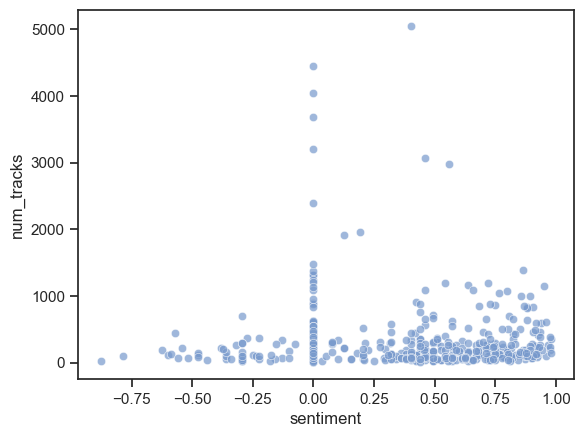

In [26]:
sns.scatterplot(x=playlist_df['sentiment'], y=playlist_df['num_tracks'], color='#79C', alpha=0.7)

### Most Negative Descriptions?
real.

In [39]:
playlist_df.sort_values(by='sentiment').head(10)

playlist_id  num_tracks  \
687  6pWnvua8QlxWF0Y7Qdok5r          19   
114  1BC7DsARF1AbyFwyfGl0ay          97   
45   0Ver1JN2EzqOOsTP4ovQdA         187   
303  34jLjd5Eq8HmHfqzvDPxsF         115   
700  6x5mHTWHcGimLKiwzB17HM         136   
309  373UgX5kxPt6bFKptF3xx0         451   
765  7qXwdAdxlhJGYztZquzf3O          66   
741  7bFDebmY42iGKA3S7fBYB5         220   
397  3wEmPc5MSsirtpAjcyq3Qm          66   
743  7cR2zrseVvAVBOBAPem6Bj          79   

                                           description  sentiment  \
687  you can&#x27;t be antisocial, depressed, have ...    -0.8779   
114  “now i am become death, the destroyer of worlds.”    -0.7845   
45                          existential crisis at 3 am    -0.6249   
303    beetje klassieke muziek voor die breincelletjes    -0.5994   
700  when im sitting in the college that scams me o...    -0.5859   
309                       i need utter chaos to focus.    -0.5719   
765  a daily occurence (also holy shit guys i’m lik...    -0.5574   
741                                 don’t fail physics    -0.5423   
397  an occasion to morn the loss of never learning...    -0.5165   
743  Sometimes Lo-Fi beats or words get in my way, ...    -0.4767   

                                    name  
687              toxic study motivation   
114           studying like oppenheimer   
45           studying philosophy at 3 am  
303                           Study sesh  
700          study music but not boring   
309                      adhd studyin’ 😎  
765  instrumentals for reading/studying   
741                    oppenheimer study  
397                   soft library study  
743                  Studying Orchestral

### Part 2: Exploring the playlists

In [53]:
def get_song_name(id_list):
    return sp.track(id_list, market='us')['name']

In [46]:
study_tracks = study_tracks.groupby('id').max().reset_index()

In [48]:
study_tracks = study_tracks.drop(columns = ['cluster', 'name'])

In [49]:
study_tracks.to_csv('study_tracks.csv', index=False)

In [50]:
study_tracks = pd.read_csv('study_tracks.csv')

study_tracks.describe()

danceability        energy           key      loudness          mode  \
count  80873.000000  80873.000000  80873.000000  80873.000000  80873.000000   
mean       0.514417      0.334439      5.108046    -15.461001      0.601635   
std        0.205343      0.256374      3.542103      7.734932      0.489564   
min        0.000000      0.000000      0.000000    -50.514000      0.000000   
25%        0.368000      0.118000      2.000000    -20.188000      0.000000   
50%        0.544000      0.280000      5.000000    -14.369000      1.000000   
75%        0.676000      0.505000      8.000000     -9.435000      1.000000   
max        0.991000      1.000000     11.000000      2.621000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  80873.000000  80873.000000      80873.000000  80873.000000   
mean       0.070033      0.640031          0.641170      0.154824   
std        0.075792      0.358696          0.375586      0.132351   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.037100      0.303000          0.275000      0.096900   
50%        0.045100      0.803000          0.856000      0.111000   
75%        0.063900      0.958000          0.919000      0.144000   
max        0.959000      0.996000          1.000000      1.000000   

            valence         tempo   duration_ms  time_signature         count  
count  80873.000000  80873.000000  8.087300e+04    80873.000000  80873.000000  
mean       0.301887    112.676093  1.883715e+05        3.824812      1.734312  
std        0.234600     33.386801  9.893833e+04        0.571761      2.176458  
min        0.000000      0.000000  2.508000e+03        0.000000      1.000000  
25%        0.107000     83.630000  1.288080e+05        4.000000      1.000000  
50%        0.243000    110.029000  1.728280e+05        4.000000      1.000000  
75%        0.447000    136.057000  2.250270e+05        4.000000      2.000000  
max        1.000000    245.294000  3.600022e+06        5.000000     89.000000

In [ ]:
# Scale data 
scaler = StandardScaler()
envind_scaled = scaler.fit_transform(envind_dropnames)

# Create a KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state = 1234, n_init = 'auto')

# Fit the model to the data
kmeans.fit(envind_scaled)

# Get the labels for each point
envind['epi_cl'] = kmeans.labels_

In [64]:
cols_to_use = ['danceability', 'energy', 'mode', 'loudness', 'speechiness', 'acousticness', 
               'instrumentalness','liveness', 'valence', 'tempo']
# selecting features for model
kmeans_df = study_tracks[cols_to_use]

# normalize feature values
scaler = StandardScaler()
kmeans_scaled = scaler.fit_transform(kmeans_df)

# sum of squared diff
sse = [] 

# fit kmeans model with 30 clusters 
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state = 1234, n_init = 'auto')
    kmeans.fit(kmeans_scaled)
    sse.append(kmeans.inertia_)  # add sum of squared distances for the current number of clusters to the list

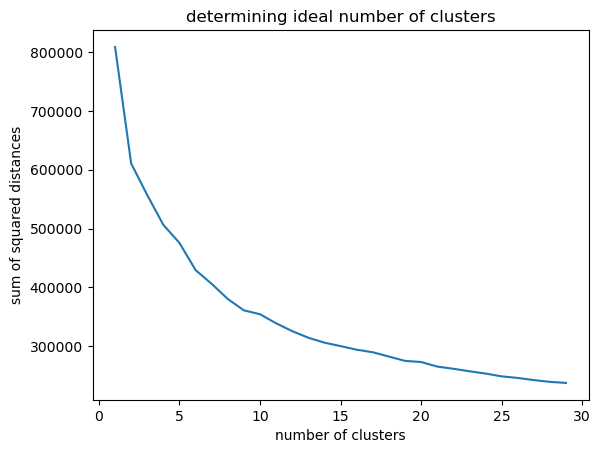

In [65]:
# plot the sum squared distances for each number of clusters for elbow method

plt.plot(range(1, 30), sse)
plt.title('determining ideal number of clusters')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distances')
plt.show()

#### It looks like sse decreases when the number of clusters increase, which is to be expected
However, too many clusters can mean overfitting, and I don't have that many ideas for study personality types LOL. 

So let's go with 16 clusters

In [54]:
# running kmeans with 16 clusters
kmeans = KMeans(n_clusters=16, random_state = 1234, n_init = 'auto')

# Fit the model to the data
kmeans.fit(kmeans_scaled)

# Get the labels for each point
study_tracks['cluster'] = kmeans.labels_

study_tracks.head()

id  danceability  energy  key  loudness  mode  \
0  000tG7ZCNMDFLzIxobVSUZ         0.431  0.0486    6   -23.585     1   
1  000thNcQZnKO2T6sqRegqB         0.663  0.4520    5    -5.938     1   
2  001UkMQHw4zXfFNdKpwXAF         0.573  0.8460    7    -4.866     1   
3  001VMKfkHZrlyj7JlQbQFL         0.168  0.0354    9   -25.340     0   
4  0028HjBkFVbYKlpopdaIMo         0.186  0.3260    7   -11.630     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0334       0.99400          0.906000     0.107   0.3450  156.648   
1       0.0310       0.25000          0.000000     0.107   0.9130  119.892   
2       0.0344       0.00372          0.000079     0.290   0.5620  127.061   
3       0.0498       0.27500          0.929000     0.205   0.0301  113.659   
4       0.0348       0.86900          0.687000     0.102   0.0880   72.908   

   duration_ms  time_signature  count  cluster  
0       160091               3      1       14  
1       114242               4      1        6  
2       191053               4      1        6  
3       120840               3      3        3  
4        63599               4      1        3

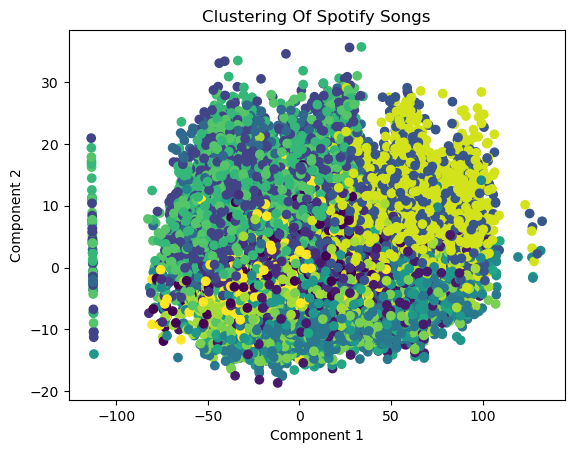

In [58]:
cols_to_use = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
               'instrumentalness','liveness', 'valence', 'tempo']
# selecting features for model
pca_df = study_tracks[cols_to_use]


    #To visualize the generated clusters, we will first need to reduce the data to two dimensions
# so that we can plot it on a scatter plot

pca = PCA(n_components=2)  # Initialize a PCA model with 2 components
pca_2d = pca.fit_transform(pca_df)  # Reduce the data to two dimensions using the PCA model

# Plot the data points on a scatter plot
# Coloring the data points according to their cluster assignment
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.title('Clustering Of Spotify Songs')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

IndexError: index 16 is out of bounds for axis 0 with size 16

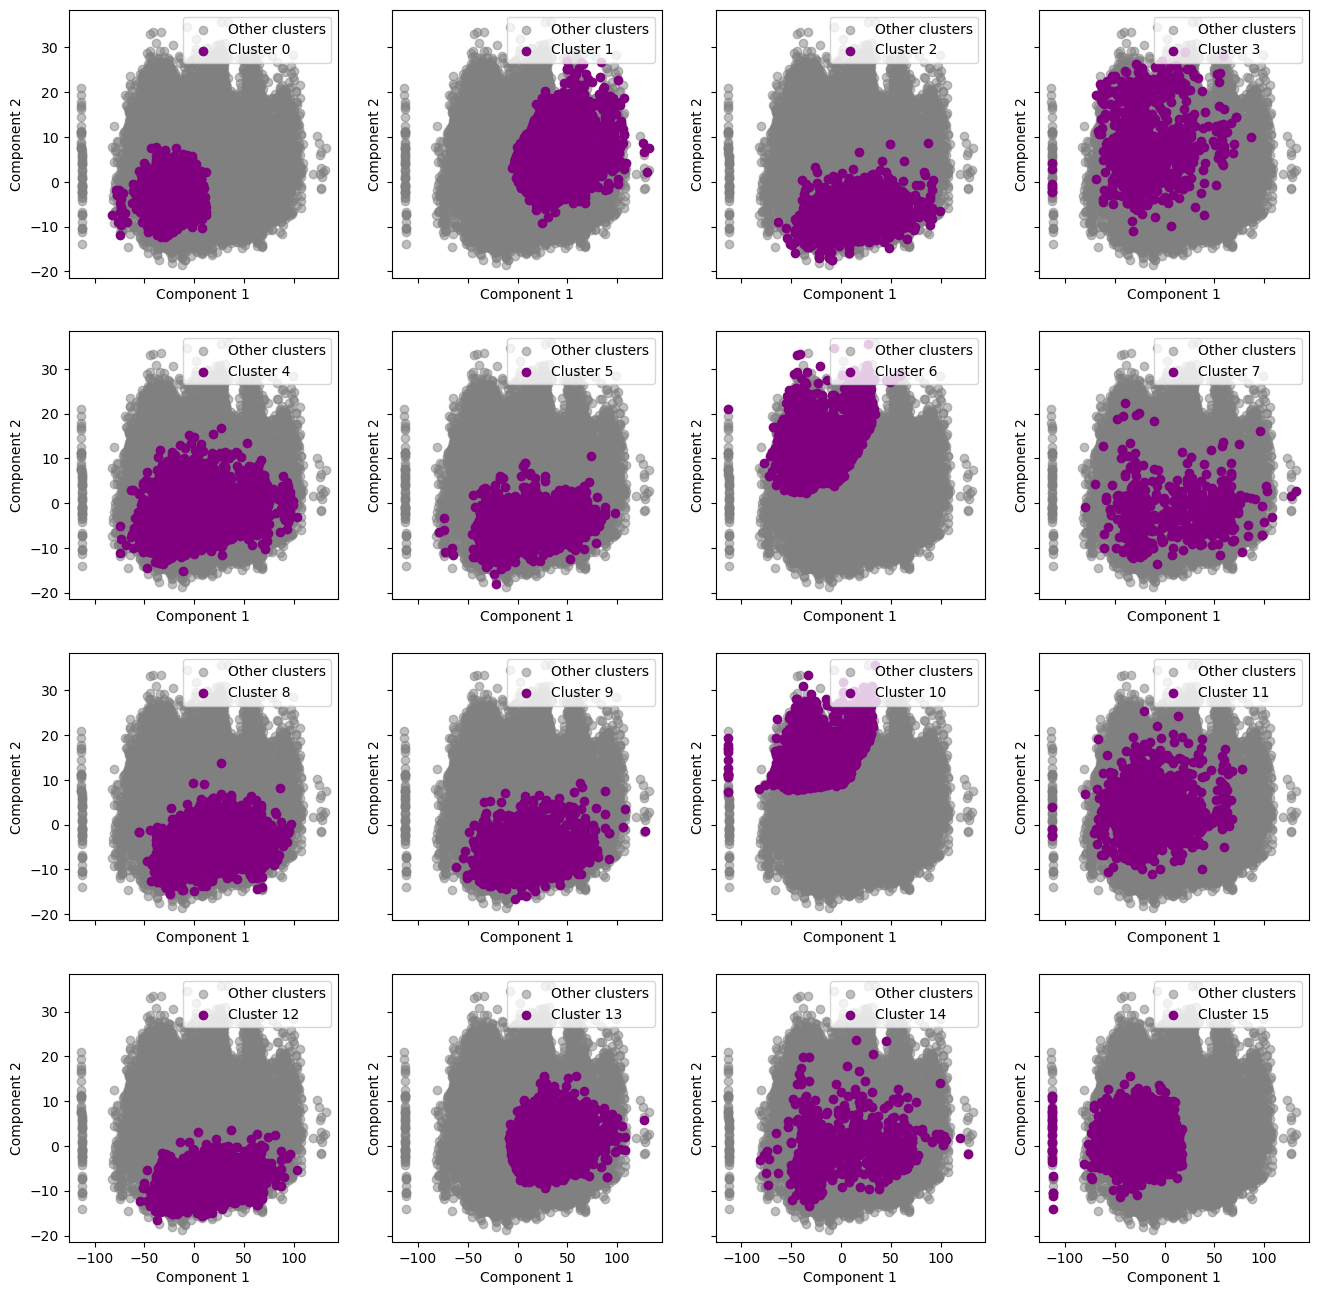

In [79]:
clusters = kmeans.labels_
unique_clusters = np.unique(clusters)

# create grid
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16), sharex=True, sharey=True)
axs = axs.flatten() # flatten array of subplots to make it easier to iterate over

for i, cluster in enumerate(unique_clusters):
    # select current cluster
    df_cluster = pca_2d[clusters == cluster]
    
    # select other clusters
    df_other_clusters = pca_2d[clusters != cluster]
    
    # plot other cluster points
    axs[i].scatter(df_other_clusters[:, 0], df_other_clusters[:, 1], c='gray', label='Other clusters', alpha=0.5)
    
    # plot current cluster points
    axs[i].scatter(df_cluster[:, 0], df_cluster[:, 1], c='purple', label='Cluster {}'.format(cluster))
    
    axs[i].set_xlabel('Component 1')
    axs[i].set_ylabel('Component 2')
    
    axs[i].legend()

plt.show()

In [77]:
study_tracks[study_tracks['cluster'] == 14].sort_values('count', ascending=False).head()

id  danceability  energy  key  loudness  mode  \
5218   0V5cvmTKsYmF5FmGGEAfmS         0.303  0.1870    2   -16.757     1   
9363   0u1mnbJLFDj8hijn6Fk4eO         0.157  0.1050    7   -28.967     1   
3653   0LgplLtg4g8N8paUWEz7GK         0.189  0.0760    3   -28.751     1   
52045  4zxTLBlDyOxvSFWcXfDhuK         0.151  0.1290    5   -29.272     1   
35935  3T7jed7DCqiFrgUw1AnY6u         0.368  0.0509   11   -27.439     1   

       speechiness  acousticness  instrumentalness  liveness  valence  \
5218        0.0356         0.989             0.489     0.101   0.2130   
9363        0.0416         0.937             0.536     0.120   0.4240   
3653        0.0699         0.911             0.622     0.110   0.0949   
52045       0.0405         0.936             0.624     0.114   0.0610   
35935       0.0333         0.959             0.866     0.140   0.4460   

         tempo  duration_ms  time_signature  count  cluster            sse  
5218   132.731       160853               4     66       14  237820.542461  
9363   134.870       134625               5     39       14  237820.542461  
3653   138.731       125375               5     39       14  237820.542461  
52045  137.951       113500               4     38       14  237820.542461  
35935  185.343        68044               3     32       14  237820.542461

In [80]:
study_tracks[study_tracks['cluster'] == 14].sort_values('count', ascending=False).head(12)

id  danceability  energy  key  loudness  mode  \
5218   0V5cvmTKsYmF5FmGGEAfmS         0.303  0.1870    2   -16.757     1   
9363   0u1mnbJLFDj8hijn6Fk4eO         0.157  0.1050    7   -28.967     1   
3653   0LgplLtg4g8N8paUWEz7GK         0.189  0.0760    3   -28.751     1   
52045  4zxTLBlDyOxvSFWcXfDhuK         0.151  0.1290    5   -29.272     1   
35935  3T7jed7DCqiFrgUw1AnY6u         0.368  0.0509   11   -27.439     1   
4280   0PaZ8LbJ42A2SoUUUlIlQC         0.376  0.0555    7   -28.725     1   
44744  4IhTXiZLKATmwhMZIb1GQN         0.440  0.0400    3   -16.887     1   
39114  3lSOZb5rruEnFbe9xWELF6         0.348  0.1690    1   -18.450     1   
39733  3p4hRhMcb6ch8OLtATMaLw         0.406  0.3990    7   -10.449     1   
29237  2osMu8c4ahjQGQ7gsRQw8I         0.258  0.2790    1   -15.896     1   
10211  0z6gRI7XGqBbfz2xd9RFz0         0.142  0.0486    8   -29.805     1   
7139   0gsBQy8Q0eWlR67xDmoWFw         0.279  0.2340    7   -17.515     1   

       speechiness  acousticness  instrumentalness  liveness  valence  \
5218        0.0356         0.989             0.489    0.1010   0.2130   
9363        0.0416         0.937             0.536    0.1200   0.4240   
3653        0.0699         0.911             0.622    0.1100   0.0949   
52045       0.0405         0.936             0.624    0.1140   0.0610   
35935       0.0333         0.959             0.866    0.1400   0.4460   
4280        0.0365         0.764             0.824    0.3800   0.1060   
44744       0.0322         0.981             0.465    0.1110   0.2490   
39114       0.0413         0.959             0.889    0.1000   0.1070   
39733       0.0278         0.756             0.678    0.1120   0.1630   
29237       0.0613         0.954             0.907    0.1140   0.0345   
10211       0.0546         0.813             0.743    0.1080   0.2870   
7139        0.0396         0.975             0.871    0.0908   0.2400   

         tempo  duration_ms  time_signature  count  cluster            sse  
5218   132.731       160853               4     66       14  237820.542461  
9363   134.870       134625               5     39       14  237820.542461  
3653   138.731       125375               5     39       14  237820.542461  
52045  137.951       113500               4     38       14  237820.542461  
35935  185.343        68044               3     32       14  237820.542461  
4280   141.204        94662               3     32       14  237820.542461  
44744  135.965       193749               4     27       14  237820.542461  
39114  138.877       111443               3     26       14  237820.542461  
39733  142.830       256800               4     23       14  237820.542461  
29237  168.148        65681               3     22       14  237820.542461  
10211  141.760       122266               4     22       14  237820.542461  
7139   163.883       172187               1     20       14  237820.542461

In [ ]:
def get_x_track_playlist(user_id, cluster_num, num_tracks):
    playlist_name = 'amazing study playlist'
    mini_playlist = study_tracks[study_tracks['cluster'] == cluster_num].sort_values('count', ascending=False).head(num_tracks)
    tracks = mini_playlist['id']
    sp.user_playlist_create(user, name, public=True, collaborative=False, description='')
    sp.user_playlist_add_tracks(user, playlist_id, tracks, position=None)
    
    
    